floyd run --gpu --mode jupyter --data itimmis/datasets/steering_new:steering_new

In [1]:
# For deep learning
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf

# Synthetic data generation (image augmentation)
from keras.preprocessing.image import ImageDataGenerator

# For image manipulation
from sklearn.feature_extraction import image
import scipy.misc

# For math
import numpy as np
from numpy import random
import math

# For file manipulation
import os
import glob
import pickle

# For graphing
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# For reading images
from matplotlib.image import imread

# For data manipulation
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
def save_training_history(history1, history2):

    save_data = (history1, history2)
    pickle_out = open('history.pickle', 'wb')
    pickle.dump(save_data, pickle_out)
    pickle_out.close()
    
    return

In [3]:
def load_training_history():

    pickle_in = open('history.pickle', 'rb')        
    (history1, history2) = pickle.load(pickle_in)
    
    return (history1, history2)

In [4]:
def generator(data_dict, batch_size):
    
    # This function generates each mini-batch one at a time
    
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, data_dict["x_train"][1].shape[0], data_dict["x_train"][1].shape[1], data_dict["x_train"][1].shape[2]))
    batch_labels = np.zeros((batch_size, 1))
   
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = random.choice(len(data_dict["x_train"]),1)
            batch_features[i] = data_dict["x_train"][index]
            batch_labels[i] = data_dict["y_train"][index]
        yield batch_features, batch_labels

In [5]:
def radians_to_degrees(x):
    deg = math.degrees(x + math.pi)
    return deg

In [6]:
def degrees_to_radians(x):
    rad = math.radians(x) - math.pi
    return rad

In [7]:
def load_data():
    
    images = []
    labels = []
    
    cloud = True
    
    folder_names = ["campus_run1", "campus_run2", "run1", "run2", "run3", "second_spot1", "second_spot2"]
    
    if cloud == True:
        path = "/steering_new/"
    else: 
        path = "/Users/itimmis/Desktop/ACTor/Data/SteeringNew/"
    
    # Loop folders
    for folder in folder_names:
        
        # open folder
        os.chdir(path + folder)
        
        # Loop files
        for file in glob.glob("*.jpg"):

            # Load image
            images.append(imread(file))

            # Extract label
            value = file.split('_')[-1].replace('.jpg','') # Remove the idx from filepath
            labels.append(radians_to_degrees(float(value)))
        
    # Convert to numpy arrays
    x = np.array(images)
    y = np.array(labels)
    
    # Extract Test Set
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Extract Validation Set
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)
    
    # Normalize images
    x_train = x_train / 255.
    x_val = x_val / 255.
    x_test = x_test / 255.
    
    # Create data dictionary to contain train,val,test sets
    data_dict = {
        "x_train":x_train,
        "y_train":y_train,
        "x_val":x_val,
        "y_val":y_val,
        "x_test":x_test,
        "y_test":y_test
    }
    
    return data_dict

In [8]:
def init_model(data_dict, hyperparameters):
    
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=data_dict["x_train"][1].shape)
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # add a fully-connected layer
    x = Dense(hyperparameters["fc_size"], activation=hyperparameters["fc_activation"])(x)
    
    # add a logistic layer
    predictions = Dense(1, kernel_initializer='normal')(x)
    
    # train this model
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='adam', loss=hyperparameters["loss"], metrics=hyperparameters["metrics"])
    
    return model

In [9]:
#def main():

# Hyperparameters
hyperparameters = {
    "batchsize" : 32,
    "fc_size" : 1024,
    "fc_activation" : 'relu',
    "epoch_finetune" : 30,
    "epoch_transfer" : 30,
    "loss" : "mean_squared_error",
    "metrics" : None,#["accuracy"]
    "monitor" : 'val_loss'
}

# # Load steering images
data_dict = load_data()

# # Create model
model = init_model(data_dict, hyperparameters)

m = data_dict["x_train"].shape[0]

# Train model
#train_model(data_dict, hyperparameters)

#    return

87818240/87910968 [============================>.] - ETA: 0s

In [ ]:
# def train_model(data_dict, hyperparameters):
    
top_weights_path = "/output/top_weights.h5"

# Early Stopping and Model Checkpoint callbacks
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor=hyperparameters["monitor"], verbose=1, save_best_only=True),
    EarlyStopping(monitor=hyperparameters["monitor"], patience=5, verbose=0)
]

# train the model on the new data for a few epochs
history1 = model.fit_generator(generator(data_dict, hyperparameters["batchsize"]), steps_per_epoch= m / hyperparameters["batchsize"], 
                    epochs=hyperparameters["epoch_finetune"], callbacks=callbacks_list, validation_data=(data_dict["x_val"], data_dict["y_val"]))


model.load_weights(top_weights_path)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Early Stopping and Model Checkpoint callbacks
final_weights_path = "/output/final_weights.h5"
callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor=hyperparameters["monitor"], verbose=1, save_best_only=True),
    EarlyStopping(monitor=hyperparameters["monitor"], patience=5, verbose=0)
]

from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=hyperparameters["loss"], metrics=hyperparameters["metrics"])

history2 = model.fit_generator(generator(data_dict,hyperparameters["batchsize"]), steps_per_epoch= m / hyperparameters["batchsize"], 
                    epochs=hyperparameters["epoch_transfer"], callbacks=callbacks_list, validation_data=(data_dict["x_val"], data_dict["y_val"]))

    # Save the transfer learning and fine tuning history
    #save_training_history(history1, history2)
    
#     return

Epoch 1/30
87/86 [==============================] - 194s - loss: 1044.1471 - val_loss: 909.5725
Epoch 2/30
87/86 [==============================] - 191s - loss: 893.6656 - val_loss: 877.2545
Epoch 3/30
87/86 [==============================] - 191s - loss: 972.5712 - val_loss: 854.6391
Epoch 4/30
87/86 [==============================] - 191s - loss: 919.4361 - val_loss: 822.8937
Epoch 5/30
87/86 [==============================] - 191s - loss: 993.9919 - val_loss: 785.9591
Epoch 6/30
87/86 [==============================] - 191s - loss: 844.0527 - val_loss: 754.1002
Epoch 7/30
87/86 [==============================] - 190s - loss: 863.9704 - val_loss: 715.7451
Epoch 8/30
87/86 [==============================] - 191s - loss: 810.7208 - val_loss: 682.3691
Epoch 9/30
87/86 [==============================] - 191s - loss: 785.9092 - val_loss: 658.2428
Epoch 10/30
87/86 [==============================] - 191s - loss: 838.8687 - val_loss: 661.3228
Epoch 11/30
87/86 [=============================

87/86 [==============================] - 213s - loss: 645.8177 - val_loss: 389.2373
Epoch 9/30
87/86 [==============================] - 212s - loss: 653.6320 - val_loss: 412.3415
Epoch 10/30
87/86 [==============================] - 212s - loss: 648.3177 - val_loss: 404.0928
Epoch 11/30
87/86 [==============================] - 213s - loss: 735.6710 - val_loss: 314.6741
Epoch 12/30
87/86 [==============================] - 212s - loss: 722.3355 - val_loss: 321.0565
Epoch 13/30
87/86 [==============================] - 212s - loss: 757.9247 - val_loss: 676.8160
Epoch 14/30
87/86 [==============================] - 212s - loss: 656.0270 - val_loss: 412.0039
Epoch 15/30
87/86 [==============================] - 211s - loss: 721.6577 - val_loss: 508.0298
Epoch 16/30
87/86 [==============================] - 212s - loss: 705.5209 - val_loss: 524.5211
Epoch 17/30
87/86 [==============================] - 212s - loss: 827.8999 - val_loss: 252.2381
Epoch 18/30
87/86 [==============================] - 

In [ ]:
final_weights_path = "/output/final_weights.h5"

model.load_weights(final_weights_path)

preds = model.evaluate(data_dict["x_test"], data_dict["y_test"])

print(preds)

921/921 [==============================] - 53s    
243.120762422


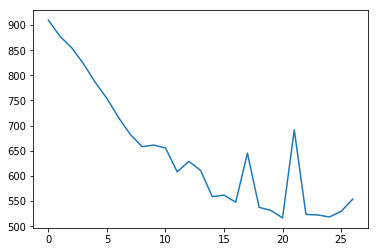

In [ ]:
plt.plot(history1.history['val_loss'])

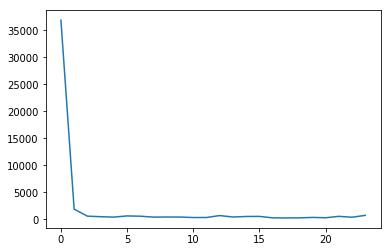

In [ ]:
plt.plot(history2.history['val_loss'])